In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import lru_cache
import time
import re
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


In [2]:

# Standard genetic code mapping (RNA codons -> amino acids, one-letter codes)
genetic_code = {
    'UUU':'F','UUC':'F','UUA':'L','UUG':'L',
    'UCU':'S','UCC':'S','UCA':'S','UCG':'S',
    'UAU':'Y','UAC':'Y','UAA':'*','UAG':'*',
    'UGU':'C','UGC':'C','UGA':'*','UGG':'W',
    'CUU':'L','CUC':'L','CUA':'L','CUG':'L',
    'CCU':'P','CCC':'P','CCA':'P','CCG':'P',
    'CAU':'H','CAC':'H','CAA':'Q','CAG':'Q',
    'CGU':'R','CGC':'R','CGA':'R','CGG':'R',
    'AUU':'I','AUC':'I','AUA':'I','AUG':'M',
    'ACU':'T','ACC':'T','ACA':'T','ACG':'T',
    'AAU':'N','AAC':'N','AAA':'K','AAG':'K',
    'AGU':'S','AGC':'S','AGA':'R','AGG':'R',
    'GUU':'V','GUC':'V','GUA':'V','GUG':'V',
    'GCU':'A','GCC':'A','GCA':'A','GCG':'A',
    'GAU':'D','GAC':'D','GAA':'E','GAG':'E',
    'GGU':'G','GGC':'G','GGA':'G','GGG':'G'
}

bases = ["U","C","A","G"]

stop_codons = ['UAA', 'UAG', 'UGA']
# map of list of codon changes possible by ADAR editing
adar_changes = {}



In [3]:
# Map ADAR changes
for nuc in bases:
    for nuc2 in bases:
        for nuc3 in bases:
            codon = nuc + nuc2 + nuc3
            if codon not in genetic_code:
                raise ValueError(f"Codon {codon} not found in genetic code")
            else:
                adar_changes[codon] = []
                if nuc == "A":
                    new_codon = "G" + nuc2 + nuc3
                    adar_changes[codon].append(new_codon)
                if nuc2 == "A":
                    new_codon = nuc + "G" + nuc3
                    adar_changes[codon].append(new_codon)
                if nuc3 == "A":
                    new_codon = nuc + nuc2 + "G"
                    adar_changes[codon].append(new_codon)
                if len(adar_changes[codon]) == 0:
                    adar_changes[codon] = [codon]
                adar_changes[codon] = list(set(adar_changes[codon]))


In [4]:
adar_changes

{'UUU': ['UUU'],
 'UUC': ['UUC'],
 'UUA': ['UUG'],
 'UUG': ['UUG'],
 'UCU': ['UCU'],
 'UCC': ['UCC'],
 'UCA': ['UCG'],
 'UCG': ['UCG'],
 'UAU': ['UGU'],
 'UAC': ['UGC'],
 'UAA': ['UAG', 'UGA'],
 'UAG': ['UGG'],
 'UGU': ['UGU'],
 'UGC': ['UGC'],
 'UGA': ['UGG'],
 'UGG': ['UGG'],
 'CUU': ['CUU'],
 'CUC': ['CUC'],
 'CUA': ['CUG'],
 'CUG': ['CUG'],
 'CCU': ['CCU'],
 'CCC': ['CCC'],
 'CCA': ['CCG'],
 'CCG': ['CCG'],
 'CAU': ['CGU'],
 'CAC': ['CGC'],
 'CAA': ['CAG', 'CGA'],
 'CAG': ['CGG'],
 'CGU': ['CGU'],
 'CGC': ['CGC'],
 'CGA': ['CGG'],
 'CGG': ['CGG'],
 'AUU': ['GUU'],
 'AUC': ['GUC'],
 'AUA': ['AUG', 'GUA'],
 'AUG': ['GUG'],
 'ACU': ['GCU'],
 'ACC': ['GCC'],
 'ACA': ['GCA', 'ACG'],
 'ACG': ['GCG'],
 'AAU': ['GAU', 'AGU'],
 'AAC': ['AGC', 'GAC'],
 'AAA': ['GAA', 'AGA', 'AAG'],
 'AAG': ['AGG', 'GAG'],
 'AGU': ['GGU'],
 'AGC': ['GGC'],
 'AGA': ['AGG', 'GGA'],
 'AGG': ['GGG'],
 'GUU': ['GUU'],
 'GUC': ['GUC'],
 'GUA': ['GUG'],
 'GUG': ['GUG'],
 'GCU': ['GCU'],
 'GCC': ['GCC'],
 'GCA': ['GC

In [5]:

# Create a wheel plot to visualize codon changes
def plot_codon_wheel(adar_changes, genetic_code):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')

    num_codons = len(adar_changes)
    angle_step = 2 * np.pi / num_codons

    for i, (codon, changes) in enumerate(adar_changes.items()):
        angle = i * angle_step
        radius = 1.0
        ax.plot([angle, angle], [0, radius], color='black', lw=1)

        # Plot original codon
        ax.text(angle, radius + 0.1, codon, ha='center', va='center', fontsize=10, color='blue')

        # Plot possible changes
        for j, new_codon in enumerate(changes):
            if new_codon != codon:
                change_angle = angle + (j + 1) * (angle_step / (len(changes) + 1))
                ax.plot([angle, change_angle], [radius, radius + 0.5], color='red', lw=1)
                ax.text(change_angle, radius + 0.6, new_codon, ha='center', va='center', fontsize=8, color='red')

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title('Codon Changes by ADAR Editing', va='bottom')
    plt.show()

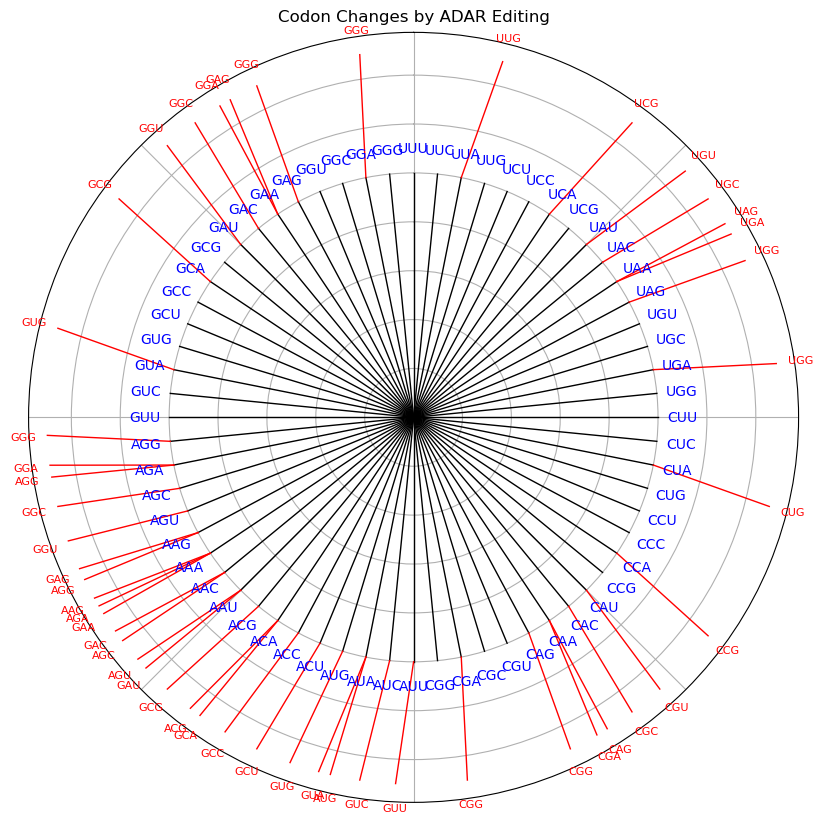

In [6]:
plot_codon_wheel(adar_changes, genetic_code)

In [7]:
def rescue_nuc_pos(codon):
    if codon is None:
        return None
    if codon.upper() not in stop_codons:
        return None
    positions = []
    if codon[1].upper() == 'A':
        positions.append(2)
    if codon[2].upper() == 'A':
        positions.append(3)
    return positions if positions else None

In [8]:
def get_var_pos_in_codon(vep_codon: str) -> int | None:
    """
    Given a VEP codon string (e.g., "Ugc"), return the position of the variant within the codon (1, 2, or 3) in this example it's 1.
    If the codon is not valid, return None.
    """
    if vep_codon is None or not isinstance(vep_codon, str):
        return None

    for i in range(3):
        if vep_codon[i].isupper():
            return i + 1  # Return 1-based position
    return None

In [9]:
variants_path = '/private10/Projects/Nave_Oded_Project/extended_variants_table/Results/processed_varicarta_table_2nd_run_with_sfari.csv'
variants_df = pd.read_csv(variants_path, low_memory=False)
variants_df.head()


,chr,pos,ref,alt,AF,AFR_AF,AMR_AF,Allele,Amino_acids,BIOTYPE,...,gnomADe_NFE_AF,gnomADe_SAS_AF,miRNA,pLI_gene_value,is_ADAR_fixable,is_APOBEC_fixable,hg19,sfari_gene_score,sfari_syndromic,sfari_number_of_reports
0,1,169824927,A,G,NaN,NaN,NaN,G,-,protein_coding,...,0.000009,0.0,NaN,0.55,False,True,A,NaN,NaN,NaN
1,5,133635407,T,C,NaN,NaN,NaN,C,-,protein_coding,...,0.000019,0.0,NaN,0.00,False,False,T,NaN,NaN,NaN
2,10,55583161,T,G,NaN,NaN,NaN,G,-,protein_coding,...,NaN,NaN,NaN,0.00,False,False,T,2.0,0.0,14.0
3,15,28953439,G,A,NaN,NaN,NaN,A,-,protein_coding,...,0.000027,0.0,NaN,0.92,False,False,G,NaN,NaN,NaN
4,3,115350078,T,TTGTTT,NaN,NaN,NaN,TGTTT,-,protein_coding,...,NaN,NaN,NaN,0.01,False,False,T,NaN,NaN,NaN


In [10]:
def process_codon(codon: str) -> str:
    codon = codon.replace('T', 'U')
    codon = codon.replace('t', 'u')
    if codon.upper() not in genetic_code:
        return None
    return codon

In [11]:
# Dubugging
variants_df[variants_df['Codons'] == 'GAG/-']

,chr,pos,ref,alt,AF,AFR_AF,AMR_AF,Allele,Amino_acids,BIOTYPE,...,gnomADe_NFE_AF,gnomADe_SAS_AF,miRNA,pLI_gene_value,is_ADAR_fixable,is_APOBEC_fixable,hg19,sfari_gene_score,sfari_syndromic,sfari_number_of_reports
827,1,161023096,ACTC,A,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.97,False,False,ACTC,NaN,NaN,NaN
1234,3,52521539,AGAG,A,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.82,False,False,AGAG,NaN,NaN,NaN
7764,20,62839407,AGAG,A,NaN,NaN,NaN,-,E/-,protein_coding,...,0.002513,0.000743,NaN,1.00,False,False,AGAG,NaN,NaN,NaN
26852,9,117121999,TTCCTCCTCCTCCTCCTC,TTCCTCCTCCTCCTC,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.03,False,False,TTCCTCCTCCTCCTCCTC,NaN,NaN,NaN
75067,10,89624277,AGAG,A,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.98,False,False,AGAG,1.0,1.0,114.0
162914,16,57509806,TCTC,T,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.20,False,False,TCTC,NaN,NaN,NaN
164316,5,122154616,TGAG,T,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,1.00,False,False,TGAG,NaN,NaN,NaN
164331,17,73898122,GCTC,G,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.00,False,False,GCTC,NaN,NaN,NaN
170800,X,54011416,CCTC,C,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,1.00,False,False,CCTC,NaN,1.0,17.0
180420,4,99823091,TCTC,T,NaN,NaN,NaN,-,E/-,protein_coding,...,NaN,NaN,NaN,0.98,False,False,TCTC,2.0,0.0,15.0


In [12]:
# the regex should make patterns like NNN/NNN and leave only NNN the 
variants_df['alt_codon'] = variants_df['Codons'].str.replace(r'^[^/]*/', '', regex=True)
variants_df['alt_codon'] = variants_df['alt_codon'].apply(process_codon)
variants_df[['Codons', 'alt_codon']].head(10)

,Codons,alt_codon
0,-,None
1,-,None
2,-,None
3,-,None
4,-,None
5,-,None
6,-,None
7,-,None
8,-,None
9,-,None


In [13]:
variants_df['rescue_nuc_pos'] = variants_df['alt_codon'].apply(rescue_nuc_pos)
variants_df['rescue_nuc_pos'].value_counts()

rescue_nuc_pos
[3]       2768
[2]       1927
[2, 3]     874
Name: count, dtype: int64

In [14]:
variants_df["edits_num"] = variants_df['rescue_nuc_pos'].apply(lambda x: len(x) if isinstance(x, list) else None)
variants_df["edits_num"].value_counts()

edits_num
1.0    4695
2.0     874
Name: count, dtype: int64

In [15]:
variants_df[variants_df['edits_num'] == 1].head()

,chr,pos,ref,alt,AF,AFR_AF,AMR_AF,Allele,Amino_acids,BIOTYPE,...,pLI_gene_value,is_ADAR_fixable,is_APOBEC_fixable,hg19,sfari_gene_score,sfari_syndromic,sfari_number_of_reports,alt_codon,rescue_nuc_pos,edits_num
33,14,94008885,G,A,NaN,NaN,NaN,A,W/*,protein_coding,...,1.00,True,False,G,2.0,0.0,10.0,uAg,[2],1.0
34,16,90037892,C,A,NaN,NaN,NaN,A,E/*,protein_coding,...,0.02,False,False,C,NaN,NaN,NaN,Uag,[2],1.0
135,16,2334337,C,A,NaN,NaN,NaN,A,E/*,protein_coding,...,0.00,False,False,C,NaN,NaN,NaN,Uag,[2],1.0
140,17,4859881,C,T,NaN,NaN,NaN,T,Q/*,protein_coding,...,0.00,False,False,C,NaN,NaN,NaN,Uag,[2],1.0
173,20,49510040,G,T,NaN,NaN,NaN,T,S/*,protein_coding,...,1.00,False,False,G,1.0,1.0,92.0,uAg,[2],1.0


In [16]:
variants_df['pos_in_codon'] = variants_df['alt_codon'].apply(get_var_pos_in_codon)
variants_df['pos_in_codon'].value_counts()

pos_in_codon
1.0    17079
2.0    13593
3.0    10007
Name: count, dtype: int64

In [17]:
def get_editable_positions(cDNA_position, rescue_nuc_pos, pos_in_codon):
    # coerce cDNA_position to int
    try:
        cDNA = int(cDNA_position)
    except (ValueError, TypeError):
        return None

    # coerce pos_in_codon to int
    try:
        pos = int(pos_in_codon)
    except (ValueError, TypeError):
        return None

    # handle rescue_nuc_pos
    if isinstance(rescue_nuc_pos, (list, tuple, np.ndarray)):
        candidates = rescue_nuc_pos
    elif isinstance(rescue_nuc_pos, (int, np.integer)):  # a single int
        candidates = [rescue_nuc_pos]
    else:
        return None

    # compute editable positions
    result = []
    for r in candidates:
        try:
            result.append(cDNA + (int(r) - pos))
        except (ValueError, TypeError):
            continue

    return result if result else None


In [18]:
variants_df['rescue_nuc_pos'].head()

0    None
1    None
2    None
3    None
4    None
Name: rescue_nuc_pos, dtype: object

In [19]:
variants_df['editing_cDNA_position'] = variants_df.apply(
    lambda row: get_editable_positions(
        row['cDNA_position'],
        row['rescue_nuc_pos'],
        row['pos_in_codon']
    ), axis=1
)

In [20]:
variants_df[variants_df['editing_cDNA_position'].notna()][['cDNA_position', 'editing_cDNA_position', 'Codons', 'alt_codon', 'rescue_nuc_pos', 'ref', 'alt']].head()

,cDNA_position,editing_cDNA_position,Codons,alt_codon,rescue_nuc_pos,ref,alt
33,1722,[1722],tGg/tAg,uAg,[2],G,A
34,1051,[1052],Gag/Tag,Uag,[2],C,A
135,4506,[4507],Gag/Tag,Uag,[2],C,A
140,1213,[1214],Cag/Tag,Uag,[2],C,T
143,12548,"[12549, 12550]",Aaa/Taa,Uaa,"[2, 3]",T,A


## Protein precent rescued

In [21]:
def parse_protein_position(pp: str | float | None) -> float | None:
    """
    VEP Protein_position can be '123', '123-125', '.', or NaN.
    We take the first position for ranges.
    """
    if pd.isna(pp) or pp in (None, '', '.'):
        return None
    m = re.match(r'^(\d+)(?:-\d+)?$', str(pp))
    return float(m.group(1)) if m else None

In [22]:
r = requests.get("https://rest.ensembl.org/info/ping", headers={"Accept":"application/json"}, timeout=10)
print(r.json())


{'ping': 1}


In [23]:
ENSEMBL38 = "https://rest.ensembl.org"
ENSEMBL37 = "https://grch37.rest.ensembl.org"


In [27]:


ENSEMBL38 = "https://rest.ensembl.org"
ENSEMBL37 = "https://grch37.rest.ensembl.org"

def fetch_seq_simple(ensp: str, genome: str = "38"):
    base = ENSEMBL37 if genome == "37" else ENSEMBL38
    url = f"{base}/sequence/id/{ensp}"
    for attempt in range(5):
        try:
            r = requests.get(
                url,
                headers={"Accept": "application/json"},
                params={"type": "protein"},
                timeout=20,
            )
            if r.status_code == 429:
                time.sleep(1 + attempt)
                continue
            if r.status_code == 404:
                print(f"[INFO] 404 Not Found for {ensp}")
                return ensp, None
            r.raise_for_status()
            seq = r.json().get("seq")
            if seq is None:
                print(f"[WARN] No sequence returned for {ensp}")
            return ensp, seq
        except Exception as e:
            print(f"[ERROR] Exception fetching {ensp} on attempt {attempt+1}: {e}")
            time.sleep(1 + attempt)
    print(f"[FAIL] All retries failed for {ensp}")
    return ensp, None


def fetch_sequences_simple(ensps, max_workers: int = 8, genome: str = "38"):
    results = {}
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(fetch_seq_simple, ensp, genome=genome) for ensp in ensps]
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Fetching sequences"):
            try:
                ensp, seq = fut.result()
                results[ensp] = seq
            except Exception as e:
                print(f"[ERROR] Future failed: {e}")
    return results


def fetch_enst_data(enst: str, genome_version: str = "38"):
    base = ENSEMBL37 if genome_version == "37" else ENSEMBL38
    url = f"{base}/lookup/id/{enst}"

    for attempt in range(5):
        try:
            r = requests.get(
                url,
                params={"expand": 1},
                headers={"Accept": "application/json"},
                timeout=30,
            )
            if r.status_code == 429:
                time.sleep(1 + attempt)
                continue
            r.raise_for_status()
            return r.json()
        except Exception as e:
            print(f"[ERROR] Exception fetching {enst} on attempt {attempt+1}: {e}")
            time.sleep(1 + attempt)
    raise RuntimeError(f"[FAIL] All retries failed for {url}")


In [28]:
variants_df['ENSP'].head()

0    ENSP00000356746
1    ENSP00000265334
2    ENSP00000354950
3    ENSP00000456927
4    ENSP00000377372
Name: ENSP, dtype: object

In [ ]:
# Test fetching a single sequence
ensp, seq = fetch_seq_simple('ENSP00000356746', genome='38')
print(f"Fetched sequence for {ensp}: {seq[:30]}... (length {len(seq)})")

Fetched sequence for ENSP00000356746: MGSENSALKSYTLREPPFTLPSGLAVYPAV... (length 742)


In [ ]:
# ---- integrate with your DataFrame ----
# 1) de-duplicate to avoid redundant requests
unique_ensps = (
    variants_df["ENSP"]
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)

# 2) fetch in parallel (tune max_workers if you hit rate limits)
seq_map = fetch_sequences_simple(unique_ensps, max_workers=100, genome="37")

In [33]:
# 3) map back
variants_df["protein_sequence"] = variants_df["ENSP"].astype(str).map(seq_map)

# peek
variants_df.head()

,chr,pos,ref,alt,AF,AFR_AF,AMR_AF,Allele,Amino_acids,BIOTYPE,...,hg19,sfari_gene_score,sfari_syndromic,sfari_number_of_reports,alt_codon,rescue_nuc_pos,edits_num,pos_in_codon,editing_cDNA_position,protein_sequence
0,1,169824927,A,G,NaN,NaN,NaN,G,-,protein_coding,...,A,NaN,NaN,NaN,None,None,NaN,NaN,None,MGSENSALKSYTLREPPFTLPSGLAVYPAVLQDGKFASVFVYKREN...
1,5,133635407,T,C,NaN,NaN,NaN,C,-,protein_coding,...,T,NaN,NaN,NaN,None,None,NaN,NaN,None,None
2,10,55583161,T,G,NaN,NaN,NaN,G,-,protein_coding,...,T,2.0,0.0,14.0,None,None,NaN,NaN,None,MFRQFYLWTCLASGIILGSLFEICLGQYDDDCKLARGGPPATIVAI...
3,15,28953439,G,A,NaN,NaN,NaN,A,-,protein_coding,...,G,NaN,NaN,NaN,None,None,NaN,NaN,None,MAEETQHNKLAAAKKKLKEYWQKNSPRVPAGANRNRKTNGSIPQTA...
4,3,115350078,T,TTGTTT,NaN,NaN,NaN,TGTTT,-,protein_coding,...,T,NaN,NaN,NaN,None,None,NaN,NaN,None,MTKSCSELCHPALHFLPCLGGLRKNLQRAVRPSPYSLGFLTFWISR...


In [40]:
print(variants_df[variants_df["protein_sequence"].isna()].shape)
print(variants_df[variants_df["protein_sequence"].notna()].shape)

(267146, 97)
(62289, 97)


In [ ]:
# 2nd try - fetch missing sequences again
missing_ensps = (variants_df[variants_df["protein_sequence"].isna()]["ENSP"]
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)
print(f"Retrying fetch for {len(missing_ensps)} missing ENSPs")
retry_seq_map = fetch_sequences_simple(missing_ensps, max_workers=50, genome="37")

In [43]:
# print retry_seq_map size
print(len(retry_seq_map))
print(len(seq_map))

11505
19979


In [45]:
# print the None values in retry_seq_map
print(sum(1 for v in retry_seq_map.values() if v is None))
print(sum(1 for v in seq_map.values() if v is None))

857
11505


In [46]:
# unite seq_map and retry_seq_map
seq_map.update(retry_seq_map)

In [48]:
variants_df["protein_sequence"] = variants_df["ENSP"].astype(str).map(seq_map)

In [ ]:
# 3rd try - fetch missing sequences again
missing_ensps = (variants_df[variants_df["protein_sequence"].isna()]["ENSP"]
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)
print(f"Retrying fetch for {len(missing_ensps)} missing ENSPs")
retry_seq_map = fetch_sequences_simple(missing_ensps, max_workers=50, genome="37")

In [51]:
# print retry_seq_map size
print(f"Retry seq map size: {len(retry_seq_map)}")
print(f"Seq map size: {len(seq_map)}")
# print the None values in retry_seq_map
print(f"None values in retry seq map: {sum(1 for v in retry_seq_map.values() if v is None)}")
print(f"None values in seq map: {sum(1 for v in seq_map.values() if v is None)}")
# unite seq_map and retry_seq_map
seq_map.update(retry_seq_map)
variants_df["protein_sequence"] = variants_df["ENSP"].astype(str).map(seq_map)


Retry seq map size: 857
Seq map size: 19979
None values in retry seq map: 43
None values in seq map: 43


In [52]:
# 4th try - fetch missing sequences again
missing_ensps = (variants_df[variants_df["protein_sequence"].isna()]["ENSP"]
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)
print(f"Retrying fetch for {len(missing_ensps)} missing ENSPs")
retry_seq_map = fetch_sequences_simple(missing_ensps, max_workers=50, genome="37")

Retrying fetch for 43 missing ENSPs


Fetching sequences: 100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


In [53]:
# print retry_seq_map size
print(f"Retry seq map size: {len(retry_seq_map)}")
print(f"Seq map size: {len(seq_map)}")
# print the None values in retry_seq_map
print(f"None values in retry seq map: {sum(1 for v in retry_seq_map.values() if v is None)}")
print(f"None values in seq map: {sum(1 for v in seq_map.values() if v is None)}")
# unite seq_map and retry_seq_map
seq_map.update(retry_seq_map)
variants_df["protein_sequence"] = variants_df["ENSP"].astype(str).map(seq_map)


Retry seq map size: 43
Seq map size: 19979
None values in retry seq map: 0
None values in seq map: 43


In [55]:
print(f"Number of missing protein sequences: {variants_df[variants_df['protein_sequence'].isna()].shape[0]}")
print(f"Number of available protein sequences: {variants_df[variants_df['protein_sequence'].notna()].shape[0]}")

Number of missing protein sequences: 102765
Number of available protein sequences: 226670


In [ ]:
variants_df['protein_length'] = variants_df['protein_sequence'].apply(lambda x: int(len(x)) if isinstance(x, str) else None)
variants_df['protein_length'].head()

0     742.0
1     592.0
2    1957.0
3     632.0
4     274.0
Name: protein_length, dtype: float64

In [77]:
# omit the suffix of the path and add _with_neighbors.csv
new_path = variants_path.removesuffix('.csv') + '_with_neighbors.csv'
variants_df.to_csv(new_path, index=False)

## Saved the table so I don't have to run the notebook again

In [66]:
variants_df.head()

,chr,pos,ref,alt,AF,AFR_AF,AMR_AF,Allele,Amino_acids,BIOTYPE,...,sfari_gene_score,sfari_syndromic,sfari_number_of_reports,alt_codon,rescue_nuc_pos,edits_num,pos_in_codon,editing_cDNA_position,protein_sequence,protein_length
0,1,169824927,A,G,NaN,NaN,NaN,G,-,protein_coding,...,NaN,NaN,NaN,None,None,NaN,NaN,None,MGSENSALKSYTLREPPFTLPSGLAVYPAVLQDGKFASVFVYKREN...,742.0
1,5,133635407,T,C,NaN,NaN,NaN,C,-,protein_coding,...,NaN,NaN,NaN,None,None,NaN,NaN,None,MEMYETLGKVGEGSYGTVMKCKHKNTGQIVAIKIFYERPEQSVNKI...,592.0
2,10,55583161,T,G,NaN,NaN,NaN,G,-,protein_coding,...,2.0,0.0,14.0,None,None,NaN,NaN,None,MFRQFYLWTCLASGIILGSLFEICLGQYDDDCKLARGGPPATIVAI...,1957.0
3,15,28953439,G,A,NaN,NaN,NaN,A,-,protein_coding,...,NaN,NaN,NaN,None,None,NaN,NaN,None,MAEETQHNKLAAAKKKLKEYWQKNSPRVPAGANRNRKTNGSIPQTA...,632.0
4,3,115350078,T,TTGTTT,NaN,NaN,NaN,TGTTT,-,protein_coding,...,NaN,NaN,NaN,None,None,NaN,NaN,None,MTKSCSELCHPALHFLPCLGGLRKNLQRAVRPSPYSLGFLTFWISR...,274.0


In [75]:
variants_df[(variants_df['BIOTYPE'] == 'protein_coding') & (variants_df['Protein_position'] != '-')][['Protein_position', 'protein_length']].head()

,Protein_position,protein_length
15,817,911.0
16,194,215.0
17,540,972.0
18,334,428.0
19,944,1278.0


In [82]:
# get the precent of protein rescued 
# only if Protein_position is a number (not a range or other characters)
def get_protein_rescued(row):
    if row['Protein_position'].isdigit():
        return 1 - ((int(row['Protein_position'])) / row['protein_length'])
    return None

In [ ]:
variants_df['protein_rescued'] = variants_df.apply(get_protein_rescued, axis=1)


In [96]:
variants_df[variants_df['protein_rescued'] < 0][[ 'protein_rescued','Protein_position', 'protein_length','Consequence', 'BIOTYPE']]

,protein_rescued,Protein_position,protein_length,Consequence,BIOTYPE
1767,-0.001001,1000,999.0,stop_lost,protein_coding
2727,-0.005714,176,175.0,stop_lost,protein_coding
2805,-0.004926,204,203.0,"frameshift_variant,stop_lost",protein_coding
7686,-0.004762,211,210.0,stop_lost,protein_coding
7792,-0.002941,341,340.0,"inframe_insertion,stop_retained_variant",protein_coding
8095,-0.004902,205,204.0,stop_retained_variant,protein_coding
12182,-0.000997,1004,1003.0,stop_lost,protein_coding
12455,-0.003774,266,265.0,stop_lost,protein_coding
27665,-0.001825,549,548.0,stop_lost,protein_coding
56425,-0.000863,1160,1159.0,stop_lost,protein_coding


In [111]:
variants_df[variants_df['protein_rescued'] < 0]['Consequence'].value_counts()

Consequence
stop_lost                                  32
inframe_insertion,stop_retained_variant    10
frameshift_variant,stop_lost                9
stop_retained_variant                       6
inframe_insertion                           1
Name: count, dtype: int64

In [106]:
cols = ['protein_rescued','Protein_position','protein_length','Consequence','BIOTYPE']

is_int = variants_df['Protein_position'].astype(str).str.fullmatch(r'\d+')
pp_num = variants_df.loc[is_int, 'Protein_position'].astype(int)   # convert only valid rows

mask = is_int & ((pp_num - variants_df['protein_length']) > 1)
variants_df.loc[mask, cols]


,protein_rescued,Protein_position,protein_length,Consequence,BIOTYPE


As we can see from the previous couple of cells, the rows where `protein_rescued` is negative are only on stop codons, and the `Protein_position` is larger than the `protein_length` by `1`. The `protein_length` is calculated from the `protein_sequence` field, which i got from querying ensembl REST API, which does not include the stop codon in the protein sequence.

In [112]:
variants_df.to_csv(new_path, index=False)

In [78]:
variants_df['NMD'].value_counts()

NMD
NMD_escaping_variant    4198
Name: count, dtype: int64